## Stock Data Analysis

In [3]:
# importing the libraries
import pandas as pd
import quandl
import datetime

### Getting Data

In [5]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)
 
type(apple)

pandas.core.frame.DataFrame

In [6]:
# show the first few data points
apple.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-04,102.61,105.368,102.00,105.35,67649387.0,0.0,1.0,99.136516,101.801154,98.547165,101.783763,67649387.0
2016-01-05,105.75,105.850,102.41,102.71,55790992.0,0.0,1.0,102.170223,102.266838,98.943286,99.233131,55790992.0
2016-01-06,100.56,102.370,99.87,100.70,68457388.0,0.0,1.0,97.155911,98.904640,96.489269,97.291172,68457388.0
2016-01-07,98.68,100.130,96.43,96.45,81094428.0,0.0,1.0,95.339552,96.740467,93.165717,93.185040,81094428.0
2016-01-08,98.55,99.110,96.76,96.96,70798016.0,0.0,1.0,95.213952,95.754996,93.484546,93.677776,70798016.0


### Visualize the data

Populating the interactive namespace from numpy and matplotlib


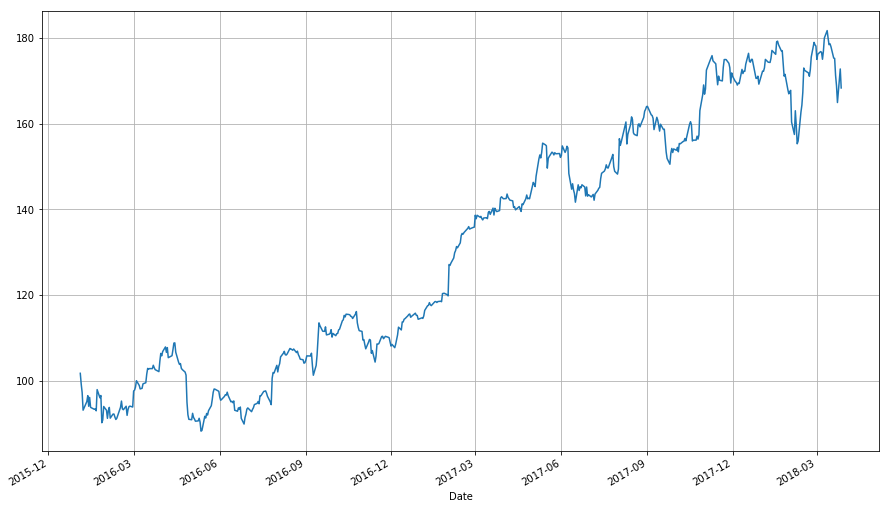

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj. Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

We would like to have some visual way to see all four variables that does not require plotting four separate lines. Financial data is often plotted with a candlestick plot. 

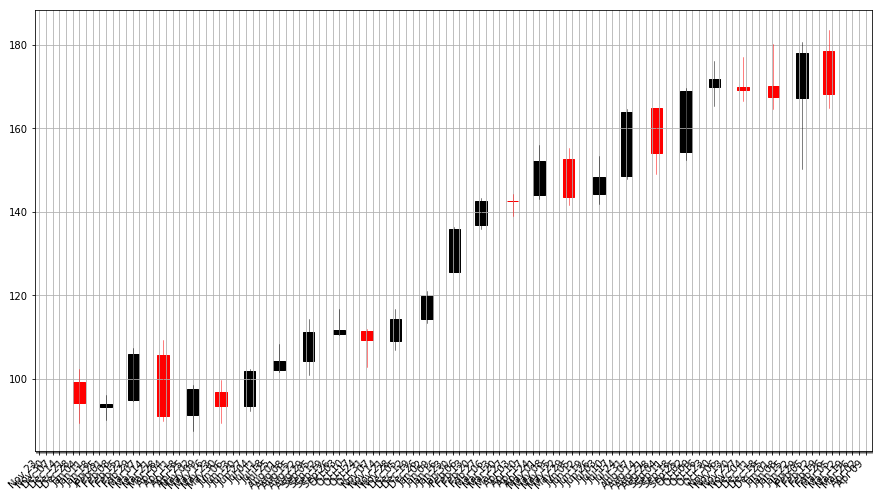

In [9]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple, adj=True, stick="month")

Getting the stock data for other companies and ploting them.

In [10]:
microsoft, google = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["MSFT", "GOOG"])
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                      "MSFT": microsoft["Adj. Close"],
                      "GOOG": google["Adj. Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,101.783763,741.84,52.181598
2016-01-05,99.233131,742.58,52.419653
2016-01-06,97.291172,743.62,51.467434
2016-01-07,93.185040,726.39,49.677262
2016-01-08,93.677776,714.47,49.829617


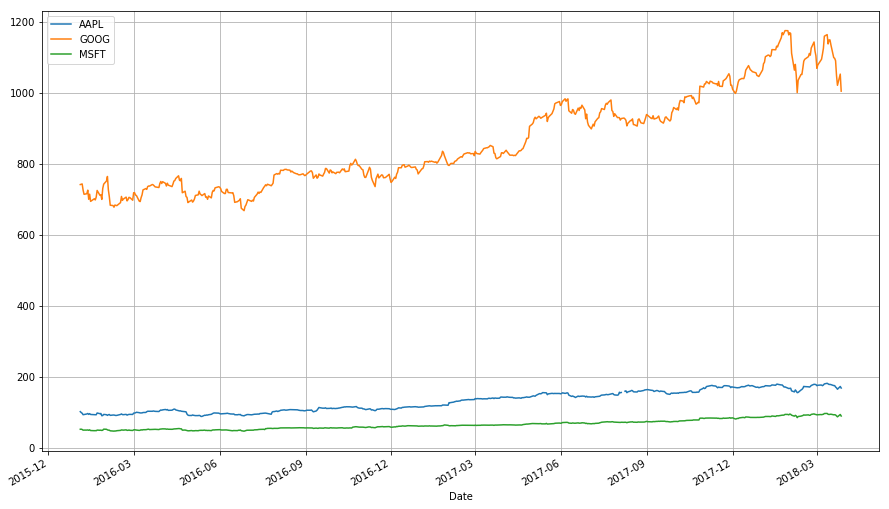

In [11]:
stocks.plot(grid=True)

Using different scales for ploting the data, one scale will be used by Apple and Microsoft stocks and the other by Google stocks.

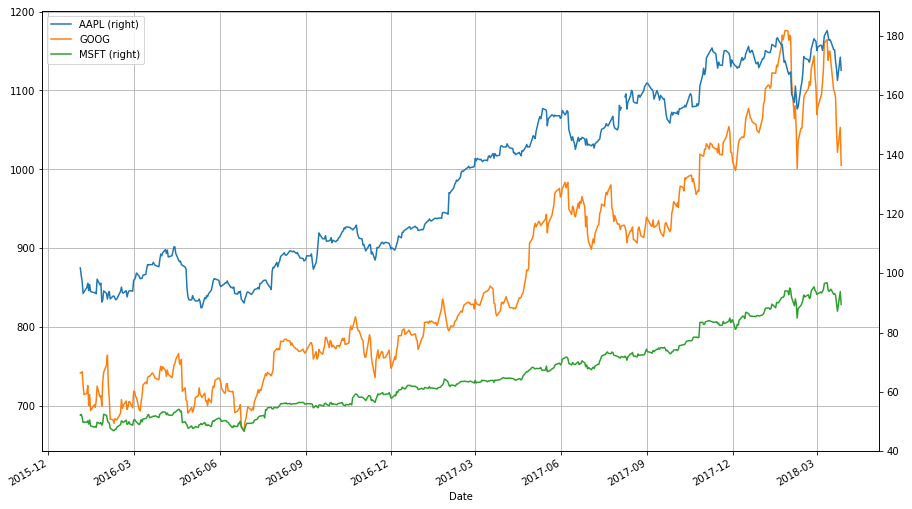

In [13]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True);

Plot the information we actually want: the stock’s returns.

In [15]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head() - 1

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,0.000000,0.000000,0.000000
2016-01-05,-0.025059,0.000998,0.004562
2016-01-06,-0.044139,0.002399,-0.013686
2016-01-07,-0.084480,-0.020827,-0.047993
2016-01-08,-0.079639,-0.036895,-0.045073


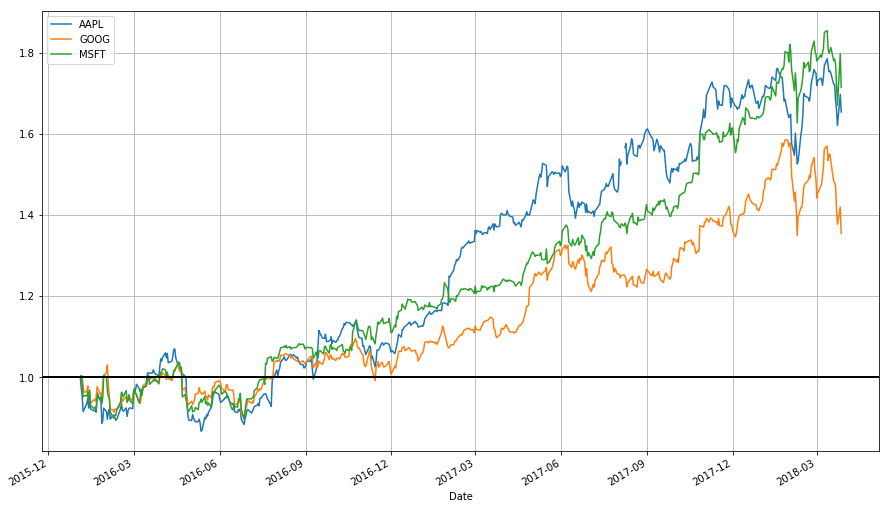

In [16]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2);

This is a much more useful plot. We can now see how profitable each stock was since the beginning of the period. Furthermore, we see that these stocks are highly correlated; they generally move in the same direction, a fact that was difficult to see in the other charts. We can plot the log difference of the data in stock.

In [17]:
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402
2016-01-08,0.005274,-0.016546,0.003062


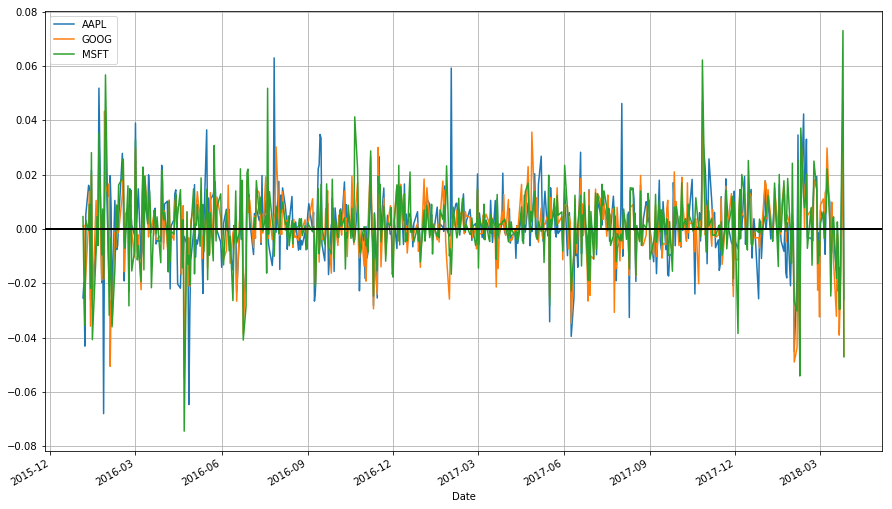

In [18]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

Get the data for SPY and compare its performance to the performance of our stocks.

In [21]:
spyderdat = pd.read_csv("/Users/ujjawalpathak/Downloads/HistoricalQuotes.csv")    # Obviously specific to my system; set to
                                                                          # location on your machine
spyderdat = pd.DataFrame(spyderdat.loc[:, ["open", "high", "low", "close", "close"]].iloc[1:].as_matrix(),
                         index=pd.DatetimeIndex(spyderdat.iloc[1:, 0]),
                         columns=["Open", "High", "Low", "Close", "Adj Close"]).sort_index()
 
spyder = spyderdat.loc[start:end]
 
stocks = stocks.join(spyder.loc[:, "Adj Close"]).rename(columns={"Adj Close": "SPY"})
stocks.head()

,AAPL,GOOG,MSFT,SPY
Date,,,,
2016-01-04,101.783763,741.84,52.181598,NaN
2016-01-05,99.233131,742.58,52.419653,NaN
2016-01-06,97.291172,743.62,51.467434,NaN
2016-01-07,93.185040,726.39,49.677262,NaN
2016-01-08,93.677776,714.47,49.829617,NaN


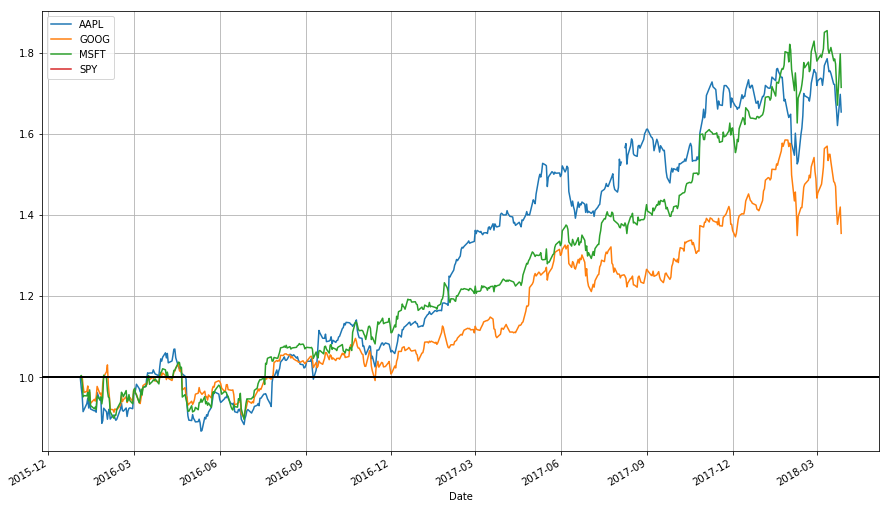

In [22]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

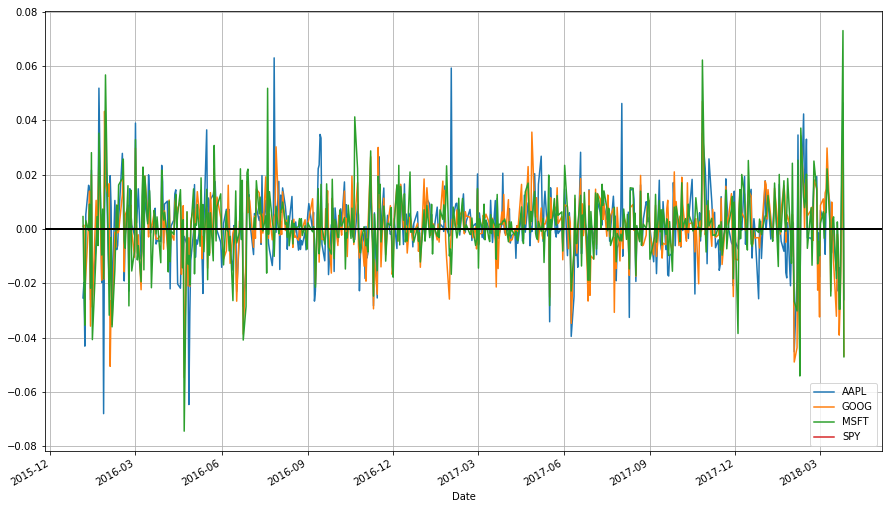

In [23]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.plot(grid=True).axhline(y = 0, color = "black", lw = 2)

Creat a 20-day (one month) moving average for the Apple data, and plotting it alongside the stock.

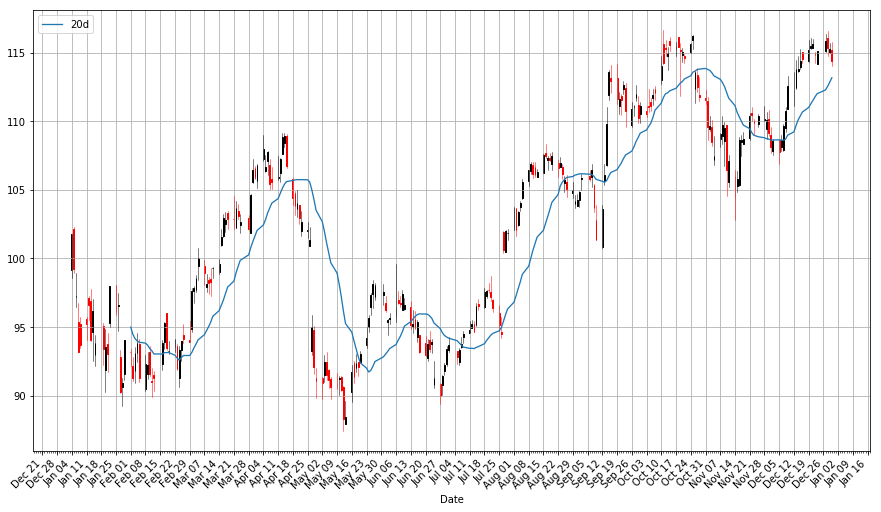

In [24]:
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)

We identify when the 20-day average is below the 50-day average, and vice versa.

In [26]:
apple["50d"] = np.round(apple["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,20d-50d
Date,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,4.37
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,4.30
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,3.96
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,3.70
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,3.36


/Users/ujjawalpathak/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,4.37,1,0.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,4.30,1,0.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,3.96,1,0.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,3.70,1,0.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,3.36,1,-1.0


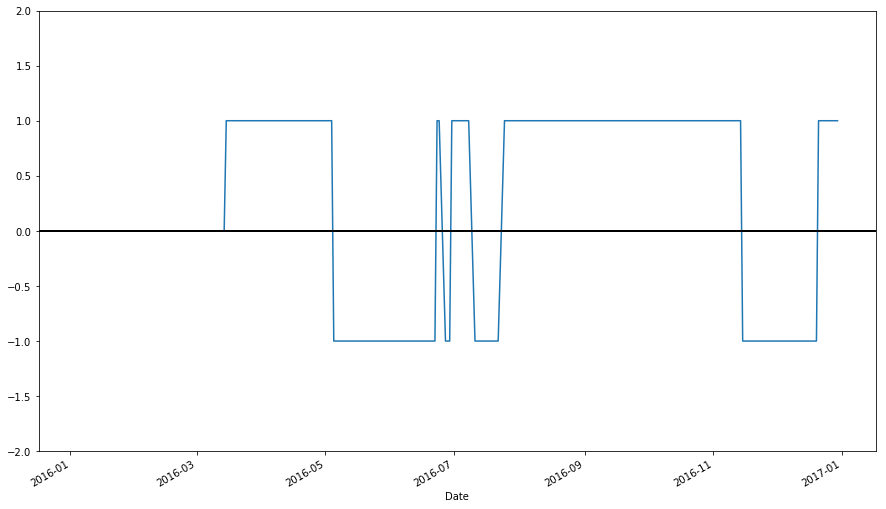

In [28]:
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-04':'2016-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.loc[:, "Regime"].iloc[-1]
apple.loc[:, "Regime"].iloc[-1] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.loc[:, "Regime"].iloc[-1] = regime_orig
apple.tail()

Now try to identify what the prices of the stocks are at every buy and sell.

In [29]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2016-03-15    104.58
2016-06-23     96.10
2016-06-30     95.60
2016-07-25     97.34
2016-12-21    117.06
2017-08-02    157.14
2017-11-01    166.89
2018-03-08    176.94
Name: Close, dtype: float64

In [30]:
apple.loc[apple["Signal"] == -1, "Close"]

Date
2016-05-05     93.24
2016-06-27     92.04
2016-07-11     96.98
2016-11-15    107.11
2017-06-27    143.74
2017-10-03    154.48
2018-02-06    163.03
2018-03-27    168.34
Name: Close, dtype: float64

In [31]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2016-03-15,101.583729,1,Buy
2016-05-05,91.122295,-1,Sell
2016-06-23,93.917337,1,Buy
2016-06-27,89.949550,-1,Sell
2016-06-30,93.428693,1,Buy
2016-07-11,94.777350,-1,Sell
2016-07-25,95.129174,1,Buy
2016-11-15,105.787035,-1,Sell
2016-12-21,115.614138,1,Buy


In [32]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2016-03-15,2016-05-05,101.583729,-10.461434
2016-06-23,2016-06-27,93.917337,-3.967788
2016-06-30,2016-07-11,93.428693,1.348657
2016-07-25,2016-11-15,95.129174,10.657861
2016-12-21,2017-06-27,115.614138,27.545001
2017-08-02,2017-10-03,156.504989,-2.024989
2017-11-01,2018-02-06,166.890000,-3.860000
2018-03-08,2018-03-27,176.940000,-8.600000


In [34]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_long_profits.index,
                            "End": apple_long_profits["End Date"]})
apple_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
apple_long_profits

,End Date,Price,Profit,Low
Date,,,,
2016-03-15,2016-05-05,101.583729,-10.461434,89.752692
2016-06-23,2016-06-27,93.917337,-3.967788,89.421814
2016-06-30,2016-07-11,93.428693,1.348657,92.158220
2016-07-25,2016-11-15,95.129174,10.657861,94.230069
2016-12-21,2017-06-27,115.614138,27.545001,113.342546
2017-08-02,2017-10-03,156.504989,-2.024989,149.160000
2017-11-01,2018-02-06,166.890000,-3.860000,154.000000
2018-03-08,2018-03-27,176.940000,-8.600000,164.940000


In [35]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2016-03-15,2016-05-05,9.905847e+05,-10.461434,101.583729,900.0,1.000000e+06,0.0,-9415.290507,91425.355735
2016-06-23,2016-06-27,9.866169e+05,-3.967788,93.917337,1000.0,9.905847e+05,0.0,-3967.787607,93917.337198
2016-06-30,2016-07-11,9.879656e+05,1.348657,93.428693,1000.0,9.866169e+05,0.0,1348.656871,93428.693404
2016-07-25,2016-11-15,9.986234e+05,10.657861,95.129174,1000.0,9.879656e+05,0.0,10657.861202,95129.173807
2016-12-21,2017-06-27,1.020659e+06,27.545001,115.614138,800.0,9.986234e+05,0.0,22036.000976,92491.310378
2017-08-02,2017-10-03,1.019444e+06,-2.024989,156.504989,600.0,1.020659e+06,0.0,-1214.993457,93902.993457
2017-11-01,2018-02-06,1.017128e+06,-3.860000,166.890000,600.0,1.019444e+06,0.0,-2316.000000,100134.000000
2018-03-08,2018-03-27,1.012828e+06,-8.600000,176.940000,500.0,1.017128e+06,0.0,-4300.000000,88470.000000
